<a href="https://colab.research.google.com/github/johntanas/it1244project/blob/main/code/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
onlinedataset=True
if onlinedataset:
  url = "https://drive.google.com/file/d/1Ktdv2NTyK2AM48yBvbpFezd82-srqj7w/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  cleaned_app_df=pd.read_csv(url,index_col=0)
  url = "https://drive.google.com/file/d/1QDhZ3u0BZX8uqMFkSWW-Ck59XvtEdxhy/view?usp=sharing"
  url='https://drive.google.com/uc?id=' + url.split('/')[-2]
  label_df=pd.read_csv(url,index_col=0)
else:
  pathtoapp="./content/cleaned_application.csv"
  cleaned_app_df=pd.read_csv(pathtoapp,index_col=0)
  pathtolabel="./content/credit_record.csv"
  label_df=pd.read_csv(pathtolabel,index_col=0)

In [3]:
dep_var="label"
random_state=42

In [4]:
train_df=label_df.merge(cleaned_app_df,how="inner")

In [5]:
cat_features = cleaned_app_df.columns[cleaned_app_df.dtypes == 'object'].to_list()

In [6]:
cleaned_app_df[cat_features].describe()

,gender,own_car,own_realty,income_type,education_level,family_status,house_type,job
count,438557,438557,438557,438557,438557,438557,438557,438557
unique,2,2,2,5,5,5,6,19
top,F,N,Y,Working,Secondary / secondary special,Married,House / apartment,Laborers
freq,294440,275459,304074,226104,301821,299828,393831,98446


We can use ordinal scaling for the factors ,even gender as there is only 2 genders and both the ordinal and nominal classification lead to 0 and 1 encoding so there is no difference. However, we have to create our own ranking for the factors with cardinality>2.

In [7]:
auto_cat_features=["gender","own_car","own_realty"]

In [8]:
for i in auto_cat_features:
    cat_features.remove(i)

In [9]:
cat_features

['income_type', 'education_level', 'family_status', 'house_type', 'job']

In [10]:
from sklearn.preprocessing import OrdinalEncoder

In [11]:
df1=cleaned_app_df.copy()

In [12]:
autoenc =OrdinalEncoder()
autoenc.fit(cleaned_app_df[auto_cat_features])
df1[auto_cat_features]=autoenc.transform(cleaned_app_df[auto_cat_features])

In [13]:
testenc =OrdinalEncoder()
testenc.fit(cleaned_app_df[cat_features])
testenc.categories_

[array(['Commercial associate', 'Pensioner', 'State servant', 'Student',
        'Working'], dtype=object),
 array(['Academic degree', 'Higher education', 'Incomplete higher',
        'Lower secondary', 'Secondary / secondary special'], dtype=object),
 array(['Civil marriage', 'Married', 'Separated', 'Single / not married',
        'Widow'], dtype=object),
 array(['Co-op apartment', 'House / apartment', 'Municipal apartment',
        'Office apartment', 'Rented apartment', 'With parents'],
       dtype=object),
 array(['Accountants', 'Cleaning staff', 'Cooking staff', 'Core staff',
        'Drivers', 'HR staff', 'High skill tech staff', 'IT staff',
        'Laborers', 'Low-skill Laborers', 'Managers', 'Medicine staff',
        'Pensioner', 'Private service staff', 'Realty agents',
        'Sales staff', 'Secretaries', 'Security staff',
        'Waiters/barmen staff'], dtype=object)]

In [14]:
categories=[['Student', 'Pensioner','Working','State servant','Commercial associate'],
     ['Lower secondary', 'Secondary / secondary special','Incomplete higher', 'Higher education', 'Academic degree'],
            ['Widow','Single / not married','Separated','Civil marriage', 'Married'],
            ['Rented apartment','With parents','Co-op apartment', 'Municipal apartment','Office apartment', 'House / apartment']]

Lets use median income level to justify the ordering of jobs instead of a biased personal heuristic!

In [15]:
job_income=dict(cleaned_app_df.groupby("job").apply(lambda x: x["income"].median()))

In [16]:
sorted_job_income={k: v for k, v in sorted(job_income.items(), key=lambda item: item[1])}

In [17]:
job_ranking=list(sorted_job_income.keys())

In [18]:
categories.append(job_ranking)

In [20]:
catenc =OrdinalEncoder(categories=categories)
catenc.fit(cleaned_app_df[cat_features])
df1[cat_features]=catenc.transform(cleaned_app_df[cat_features])

We can normalise birthday,employment length,num_child and standarise income and CNT_FAM_MEMBERS 

In [21]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler

In [22]:
num_features = cleaned_app_df.columns[cleaned_app_df.dtypes != 'object'].to_list()
num_features.remove('id')

In [23]:
cleaned_app_df[num_features]

,num_child,income,birth_day,employment_length,work_phone,phone,email,CNT_FAM_MEMBERS
0,0,427500.0,-12005,-4542,1,0,0,2.0
1,0,427500.0,-12005,-4542,1,0,0,2.0
2,0,112500.0,-21474,-1134,0,0,0,2.0
3,0,270000.0,-19110,-3051,0,1,1,1.0
4,0,270000.0,-19110,-3051,0,1,1,1.0
...,...,...,...,...,...,...,...,...
423317,0,90000.0,-13432,-5446,0,0,0,1.0
426434,2,135000.0,-12576,-4382,0,0,0,4.0
432885,0,180000.0,-9970,-119,0,0,0,2.0
421225,1,180000.0,-10630,-454,0,0,0,3.0


In [24]:
std_feature=["income","CNT_FAM_MEMBERS"]

In [25]:
for i in std_feature:
    num_features.remove(i)
norm_features=std_feature.copy()

In [26]:
norm=MinMaxScaler()
norm.fit(cleaned_app_df[norm_features])
df1[norm_features]=norm.transform(cleaned_app_df[norm_features])

In [27]:
std=StandardScaler()
std.fit(cleaned_app_df[std_feature])
df1[std_feature]=std.transform(cleaned_app_df[std_feature])

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import  KFold, cross_val_score
from sklearn.metrics import roc_auc_score

In [29]:
def kf_cross_val(model, X, y): 
    scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
        x_train = X.iloc[train_index]
        y_train = y.loc[train_index]
        x_test = X.loc[test_index]
        y_test = y.loc[test_index]
        model.fit(x_train,y_train)
        y_pred = model.predict_proba(x_test)[:,1]     
        scores.append(roc_auc_score(y_test,y_pred))       
    return scores

In [51]:
training_df=label_df.merge(df1,how="inner").drop("id",axis=1)

In [61]:
X_train=training_df[training_df.columns.difference(['label'])]
y_train=training_df["label"].copy()

In [62]:
lr = LogisticRegression(max_iter=2000, random_state=random_state)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"L2 Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

lr = LogisticRegression(max_iter=2000, penalty='none', random_state=random_state)
lr_score = kf_cross_val(lr, X_train, y_train)
print(f"No Regularization: {round(np.mean(lr_score),5)} ({round(np.std(lr_score),5)})")

L2 Regularization: 0.5181 (0.00597)
No Regularization: 0.5181 (0.00598)


It seems logistic Regression is no better than guessing due to the ordinal features in the dataset

In [39]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from sklearn.model_selection import ShuffleSplit
from fastai.tabular.all import *
from sklearn.model_selection import KFold

In [63]:
df_nn=label_df.merge(cleaned_app_df,how="inner")

In [64]:
df_nn_final=df_nn.drop("id",axis=1)

In [65]:
cont_nn,cat_nn = cont_cat_split(df_nn_final, max_card=1000, dep_var=dep_var)

In [66]:
sss = ShuffleSplit(n_splits=1, test_size=0.2)
train_idx, valid_idx = next(sss.split(train_df))
splits = (list(train_idx),list(valid_idx))

In [89]:
procs_nn = [Categorify, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [90]:
dls = to_nn.dataloaders(1024)

In [ ]:
kf = KFold(n_splits=5,random_state=random_state,shuffle=True)

In [72]:
df_nn_final[cat_nn].nunique()

gender              2
own_car             2
own_realty          2
num_child           9
income_type         5
education_level     5
family_status       5
house_type          6
work_phone          2
phone               2
email               2
job                19
dtype: int64

In [73]:
y = to_nn.train.y

In [105]:
learn = tabular_learner(dls, layers=[17,289,2],loss_func=BCEWithLogitsLossFlat())

SuggestedLRs(valley=0.009120108559727669)

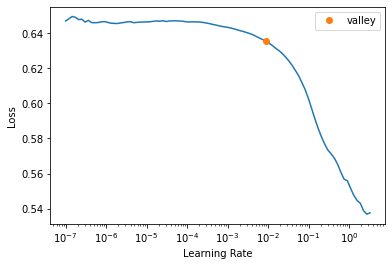

In [106]:
learn.lr_find()

In [107]:
learn.fit_one_cycle(5, 1e-2)  

epoch,train_loss,valid_loss,time
0,0.613193,0.583597,00:01
1,0.540155,0.448113,00:00
2,0.463620,0.382316,00:00
3,0.415471,0.363823,00:00
4,0.388775,0.362953,00:00


In [131]:
def hamming_distance(x,y):
  labels=np.where(preds>0.5,1,0)
  y=np.array(y)
  return sum(labels!=y)/len(x)
def hamming_distance_accuracy(x, y): return 1-hamming_distance(x,y)[0]

In [132]:
preds,targs = learn.get_preds()
hamming_distance_accuracy(preds, targs)

0.8809654415798135

SuggestedLRs(valley=0.001737800776027143)

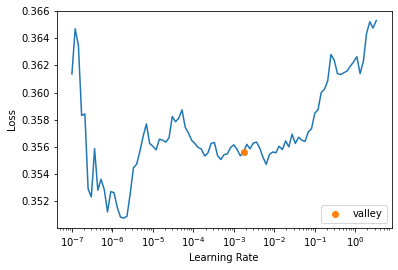

In [133]:
learn.lr_find()

In [134]:
learn.fit_one_cycle(5, 2e-3)  

epoch,train_loss,valid_loss,time
0,0.354542,0.360492,00:01
1,0.353642,0.358990,00:01
2,0.350965,0.357704,00:00
3,0.349378,0.357726,00:00
4,0.346786,0.357745,00:00


In [135]:
preds,targs = learn.get_preds()
hamming_distance_accuracy(preds, targs)

0.8809654415798135